In [1]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

try:
  from tqdm import tqdm
except ModuleNotFoundError:
  %pip install tqdm
  from tqdm import tqdm


try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

import optax
from sklearn.neighbors import NearestNeighbors

try:
  from pyDOE import *
except ModuleNotFoundError:
  ! pip install pyDOE
  from pyDOE import *

try:
  from smt.sampling_methods import LHS
except ModuleNotFoundError:
   ! pip install smt
   from smt.sampling_methods import LHS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2022-06-10 17:23:30.369930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Levy Dataset

In [2]:
xlimits = np.array([[-10.0, 10.0], [-10.0, 10.0], [-10.0, 10.0], [-10.0, 10.0]])
random_state = np.random.seed(0)
sampling = LHS(xlimits=xlimits, random_state=0 )
num = 10000
# print(num)

x = sampling(num)
X = pd.DataFrame(x)
# print(0)
w = []
for ii in X.columns:
    w.append(1 + (X[ii] - 1) / 4)

term1 = (np.sin(np.pi * w[0])) ** 2
term3 = (w[-1] - 1) ** 2 * (1 + (np.sin(2 * np.pi * w[-1])) ** 2)

sum = 0
for ii in range(len(X.columns) - 1):
    wi = w[ii]
    new = (wi - 1) ** 2 * (1 + 10 * (np.sin(np.pi * wi + 1)) ** 2)
    sum = sum + new
y = term1 + sum + term3
  # return X, y

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = scaler.transform(np.array(y_test).reshape(-1, 1))
X_train.to_csv("Datasets/Levy/X_train.csv.gz")
X_test.to_csv("Datasets/Levy/X_test.csv.gz")
pd.DataFrame(y_train).to_csv("Datasets/Levy/y_train.csv.gz")
pd.DataFrame(y_test).to_csv("Datasets/Levy/y_test.csv.gz")
# X_train, X_test, y_train, y_test = torch.tensor(np.array([X_train])).squeeze(),torch.tensor(np.array([X_test])).squeeze(),torch.tensor(np.array([y_train])).squeeze(),torch.tensor(np.array([y_test])).squeeze()
# return X_train, X_test, y_train, y_test

In [2]:
dirname = "Datasets/Levy"
X_train = pd.read_csv(dirname+"/X_train.csv.gz").iloc[:,1:]
X_test = pd.read_csv(dirname+"/X_test.csv.gz").iloc[:,1:]
y_train = pd.read_csv(dirname+"/y_train.csv.gz").iloc[:,1:]
y_test = pd.read_csv(dirname+"/y_test.csv.gz").iloc[:,1:]

X_train, X_test = jnp.array(jnp.array([X_train])).squeeze(),jnp.array([X_test]).squeeze()
y_train, y_test = jnp.array([y_train]).squeeze(),jnp.array([y_test]).squeeze() 

In [4]:
# def rbf(self, x, x_star, len_scale, varf):
#   sqdist = jnp.sum(x**2,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
#   return varf*jnp.exp(-.5 * (1/len_scale) * sqdist)

0


Text(0.5, 1.0, '10 prior samples ')

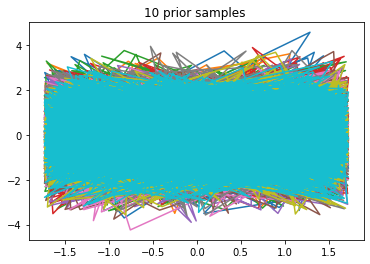

In [9]:
def prior_samples(x, key):

  # def rbf(x, x_star, len_scale, sigmaf):
  #   return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

  def rbf(x, x_star, len_scale, varf):
    sqdist = jnp.sum(x**2,1).reshape(-1,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
    return varf*jnp.exp(-.5 * (1/len_scale) * sqdist)
    
  cov = rbf(x, x, 0.1, 1)
  mean_vec = jnp.zeros(x.shape[0])
  print(0)
  prior = distrax.MultivariateNormalFullCovariance(mean_vec,cov)
  f_prior = prior.sample(seed=key, sample_shape = (10,))
  f_prior = f_prior.T
  return f_prior

f_prior = prior_samples(X_train, key)

fig = plt.figure()
plt.plot(X_train[:,0], f_prior)
plt.title("10 prior samples ")

In [3]:
class GP_Regression:

  # def rbf(self, x, x_star, len_scale,varf):
  #   return (varf)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

  def rbf(self, x, x_star, len_scale, varf):
    sqdist = jnp.sum(x**2,1).reshape(-1,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
    return varf*jnp.exp(-.5 * (1/len_scale) * sqdist)
    
  def periodic_kernel(self, x, xstar, len_scale, varf, period):
    return (varf)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))  


  def train(self,theta,data):
    X, y = data
    self.len_scale = jnp.exp(theta["log_scale"])
    self.varf = jnp.exp(theta["log_varf"])
    k = self.rbf(X,X,self.len_scale, self.varf)
    self.k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(X)))
    mean_vec= jnp.zeros(y.shape[0])
    dist = distrax.MultivariateNormalFullCovariance(mean_vec, self.k)
    dist_logprob = dist.log_prob(y.reshape(-1,))
    return -dist_logprob
  

  def posterior(self, X, y, X_test, mu_prior):
    L = jnp.linalg.cholesky(self.k)
    kstar = self.rbf(X, X_test, self.len_scale, self.varf)
    print(0)
    kstar_star = self.rbf(X_test, X_test, self.len_scale, self.varf)
    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)
    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)
    return self.mu_posterior, self.cov_posterior

In [4]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*jnp.sqrt(jnp.diag(C)),
                     m[:,0] + 1.96*jnp.sqrt(jnp.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

In [5]:
GPR = GP_Regression()

theta_init = {
  "log_varf": jnp.log(1.),
  "log_vary": jnp.log(1.),
  "log_scale": jnp.log(1.)}

#101.502873968226,121454.38823926545, 4.5781156963414125
initial_nll = GPR.train(theta_init,(X_train, y_train))
print(initial_nll)
Xnew = jnp.vstack([X_train, X_test])
mu_posterior, cov_posterior = GPR.posterior(X_train, y_train, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)

noise_matrix = 4.5781156963414125*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
plot_gp(Xnew, mu_posterior, cov_posterior+noise_matrix)
plt.plot(X_train, y_train, "b.")


6930.0979118747255


: 

: 